# JPEG Compression
 I will import the necessary libraries to implement and manipulate images

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Here is our test image and it's sahpe

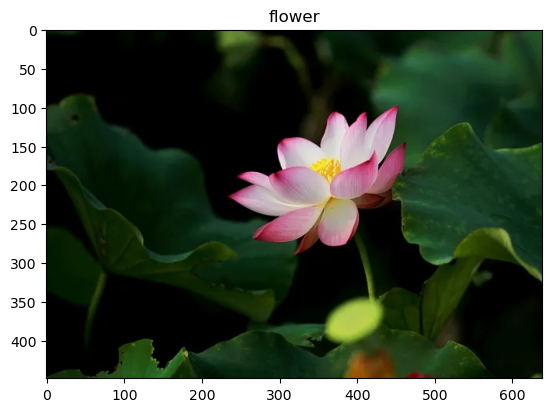

height : 449 width : 639


In [57]:
img = np.array(plt.imread("flower.webp"))
H,W = img.shape[0],img.shape[1]
plt.imshow(img)
plt.title("flower")
plt.show()
print("height : "+str(H)+" width : "+str(W))


---
## What we have ?
+ We have an image with shape **449x639x4** with **RGBA** values ranging from **0 255**
+ However since alpha value A is same for every pixel and can be represented by just 1 byte, I will ignore it and treat the image's shape as nxnxRGB meaning **449x639x3**
+ One pixel can be represented with **1 byte** or 8 bits
+ Resulting total of 286.911 bytes is needed to represent the image
> Note that this number is **hypothetical**
---
## Understanding JPEG
In JPEG a lossy compression is performed. This involves **intentional loss of data during compression**. However this lost must not effect the architecture of the image. In other words image must stay the same, **or at least it must be perceived that way.** JPEG achieve this by exploiting the weaknesses of the human eye. However what is that even mean?

There are **two kinds** of main* receptors in a human eye. **Rods** and **Cones**. Rodes are responsible of seeing in the darkness thus are more capable of sensing **brightness**. On the other hand Cones are responsible of sensing **colors**. Interestingly there are approximately **6 million Cones** and **120 million Rodes**. As a result, human eyes are **more sensitive to brightness than to color**.

**JPEG takes advantage of this property** of the human eye and uses it accordingly.This will be the first part I will be replicating.

## RGB to YCbCr

|  R    |   G      |    B   |     |
|-------|----------|--------|-----|
|0.299  |   0.587  | 0.144  | 0   |
|0.1687 |  - 0.3313|  0.5   | 128  |
|0.5    | -0.4187  |- 0.0813| 128 |

+ The Values are defined above will be the converting coefficients of RGB values to YCbCr
> Note that values are taken from the source and not experimented by myself
---
Here is the function I will be using

In [10]:
def rgb2YCbCr(tensor):
    H, W = tensor.shape[:2]
    YCbCr = np.zeros((H,W,3))
    for i in range(H):
        for j in range(W):
            YCbCr[i,j,0] =    0.299*tensor[i,j,0]  + 0.587*tensor[i,j,1]  + 0.144*tensor[i,j,2]
            YCbCr[i,j,1] = - 0.1687*tensor[i,j,0] - 0.3313*tensor[i,j,1]    + 0.5*tensor[i,j,2] + 128
            YCbCr[i,j,2] =      0.5*tensor[i,j,0] - 0.4187*tensor[i,j,1] - 0.0813*tensor[i,j,2] + 128
    return YCbCr

To visualize the Y Cb and Cr components of an image I will show a quick example of an RGB image

(321, 329, 4)


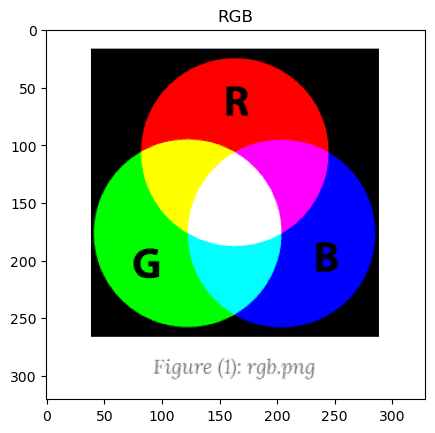

In [52]:
rgb = plt.imread("rgb.png")
plt.title("RGB")
plt.imshow(rgb)
print(rgb.shape)

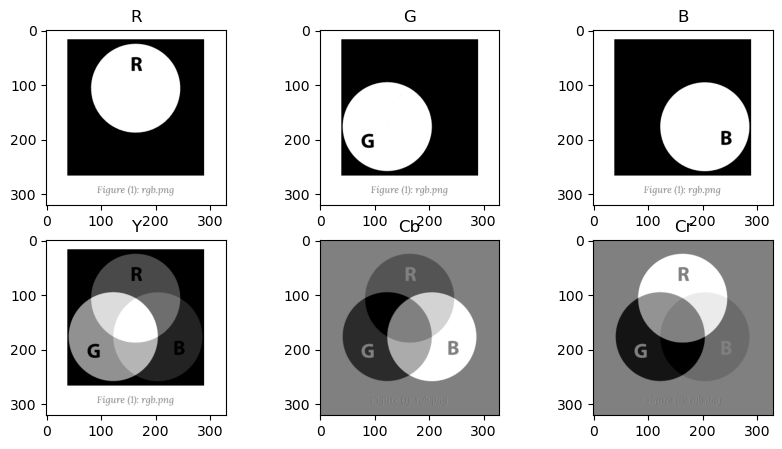

In [54]:
YCbCr = rgb2YCbCr(rgb[:,:,:3])
# Scaling the YCbCr value to 0..255
YCCmin,YCCmax = YCbCr.min(),YCbCr.max()
S_YCbCr = 255*(YCbCr-YCCmin)/(YCCmax-YCCmin)

plt.figure(figsize=(10, 5))

plt.subplot(2, 3, 1)
plt.imshow(rgb[:,:,0], cmap='gray')
plt.title('R')

plt.subplot(2, 3, 2)
plt.imshow(rgb[:,:,1], cmap='gray')
plt.title('G')

plt.subplot(2, 3, 3)
plt.imshow(rgb[:,:,2], cmap='gray')
plt.title('B')

plt.subplot(2, 3, 4)
plt.imshow(YCbCr[:,:,0], cmap='gray')
plt.title('Y')

plt.subplot(2, 3, 5)
plt.imshow(YCbCr[:,:,1], cmap='gray')
plt.title('Cb')

plt.subplot(2, 3, 6)
plt.imshow(YCbCr[:,:,2], cmap='gray')
plt.title('Cr')

plt.show()

# Reverse

After extracting the YCbCr values we need to be able to reverse the proccess and get back te original RGB values.

In [75]:
def YCbCr2rgb(tensor):
    H,W = tensor.shape[:2]
    rgb = np.zeros((H,W,3))
    for i in range(H):
        for j in range(W):
            rgb[i,j,0] = tensor[i,j,0] + 1.402*(tensor[i,j,2]-128)
            rgb[i,j,1] = tensor[i,j,0] - 0.34414*(tensor[i,j,1]-128) - 0.71414*(tensor[i,j,2]-128)
            rgb[i,j,2] = tensor[i,j,0] + 1.772*(tensor[i,j,1]-128)
    return rgb

Now to represent an image we need RGB components. Despite YCbCr values being extrcted we can't just plot them and visulize this way. Instead we will create a RGB image with **normal** values to extract the Cb and Cr components


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


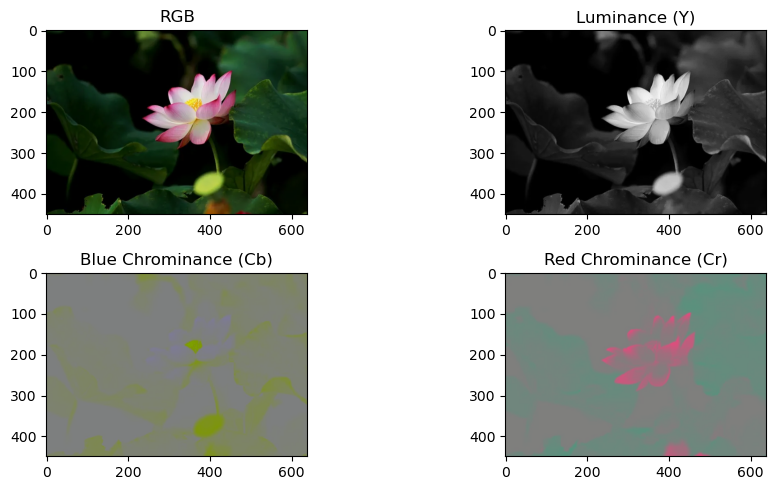

In [79]:
# Extracting the YCbCr components
YCbCr = rgb2YCbCr(flower)
H,W = YCbCr.shape[:2]
Y = YCbCr[:,:,0]
Cb = YCbCr[:,:,1]
Cr = YCbCr[:,:,2]

# Creating a normal (127) image components
z = 127 * np.ones((H, W)).astype(int)
Ysub = 127 * np.ones((H, W)).astype(int)

just_Cb = YCbCr2rgb(np.stack([Ysub, Cb, z], axis=-1)).astype(int)
just_Cr = YCbCr2rgb(np.stack([Ysub, z, Cr], axis=-1)).astype(int)

# Display the images
plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.imshow(flower)
plt.title('RGB')

plt.subplot(2, 2, 2)
plt.imshow(Y, cmap='gray')
plt.title('Luminance (Y)')

plt.subplot(2, 2, 3)
plt.imshow(just_Cb)
plt.title('Blue Chrominance (Cb)')

plt.subplot(2, 2, 4)
plt.imshow(just_Cr)
plt.title('Red Chrominance (Cr)')

plt.tight_layout()
plt.show()

Here in the above example it's clear that the previous explanation is indeed correct. Luma image is more detaily percieved than other the Chroma images. That is **the property JPEG exploits** to reduce the size of the image.

However before that there is one more think I need to clarify.
> Since all the conversion coefficient for both forward and backward transformation are floating numbers, when an image converted from rgb to YCbCr then back to the rgb, there is expected to be an error.

# Down Sampling
Next step in JPEG algorithm is down-sampling the **Cb** and **Cr** values. There are several this can be done and I will try to demonstrate as vide as possible.

+ Firstly by down-sampling we mean taking a sample of data and reducing/collapsing it to a single pixel.
+ This step is crucial because until know we havent loss any data (if we do not count the error rate).
+ This procces will reduce the size of the data significantly.
+ Secondly we will need to determine a sample size for down-sampling or a factor.
+ Factor of 2 will collapse every 4 pixel(2x2) into one pixel. Or factor of 4 will collapse every 16(4x4) pixel into one.
+ I will demonstrate the factor of **2 , 4 , 8 , 16 , 32 , 64** for simplicity this demonstration of other than 2 factors will be just for showing the difference and will not be used later.

In [83]:
factors = [2,4,8,16,32,64]
results = [[],[],[],[],[],[]]

YCbCr = rgb2YCbCr(flower)
Y,Cb,Cr = YCbCr[:,:,0],YCbCr[:,:,1],YCbCr[:,:,2]
H,W = flower.shape[:2]
for step in range(6):
    DCb = np.zeros((H,W))
    DCr = np.zeros((H,W))
    factor = factors[step]
    for i in range(0,H,factor):
        for j in range(0,W,factor):
            x = Cb[i][j]
            y = Cr[i][j]
            for k in range(factor):
                for l in range(factor):
                    if(i+k<H and j+l<W):
                        DCb[i+k][j+l] = x
                        DCr[i+k][j+l] = y
    results[step].append(DCb)
    results[step].append(DCr)

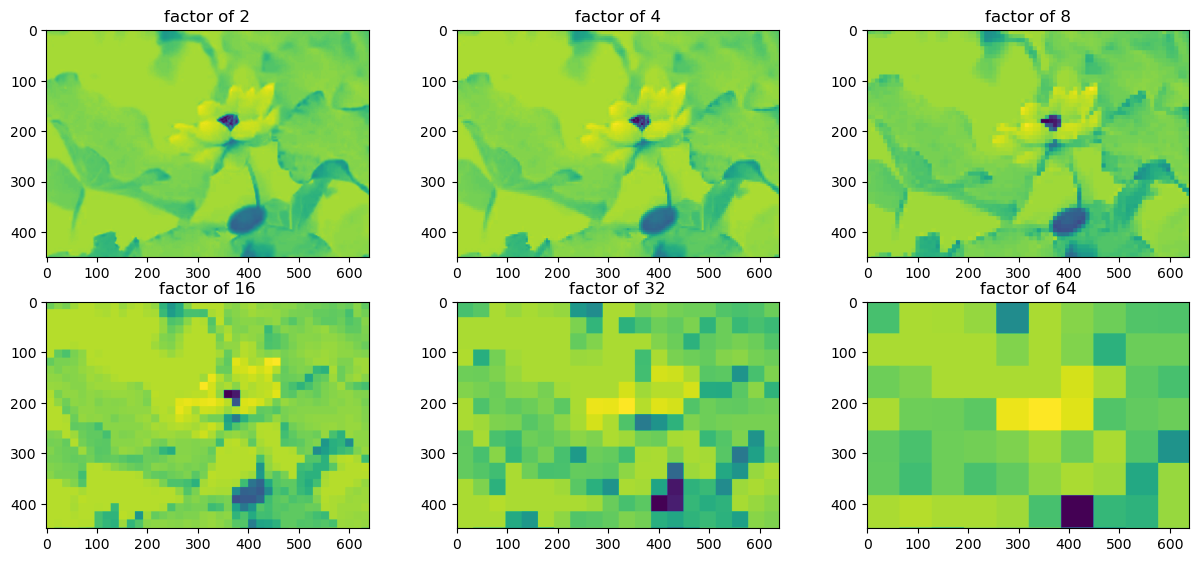

In [94]:
plt.figure(figsize=(15, 10))
for i in range(6):
    plt.subplot(3, 3, i+1)
    plt.imshow(results[i][0])
    plt.title("factor of " + str(1<<(i+1)))

It can be seen from the above image how drasticly the image decate when increasing the factor by 2. However for larger shapes of images factor can be 4 or even 8.

Next step is to look how accurate our compression was we will use the factor 2,4 and 8 as well as the first Cb and Cr are values to show the difference

---

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


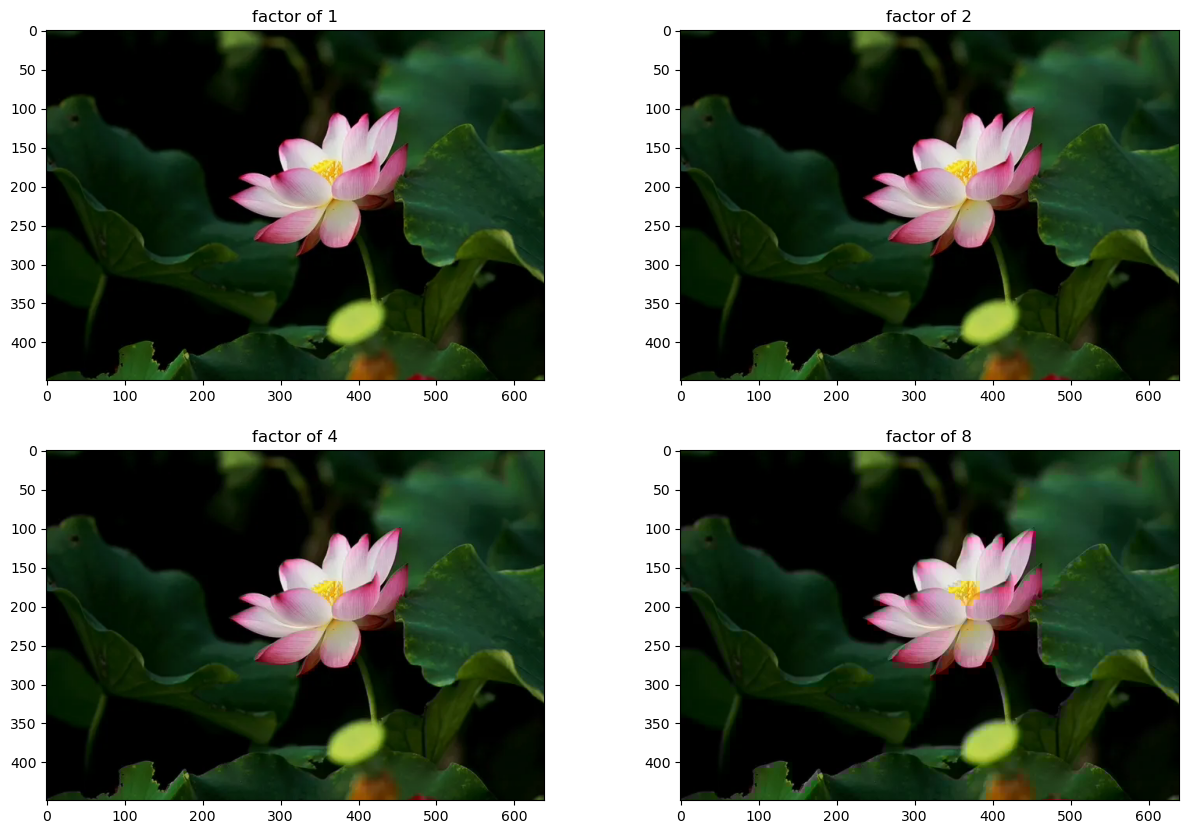

In [100]:
image_arr = [[],[],[],[]]
image_arr[0] = YCbCr2rgb(np.stack([Y, Cb,Cr], axis=-1)).astype(int)
for i in range(1,4):
    image_arr[i] = YCbCr2rgb(np.stack([Y, results[i-1][0],results[i-1][1]], axis=-1)).astype(int)
plt.figure(figsize=(15, 10))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(image_arr[i])
    plt.title("factor of " + str(1<<(i)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


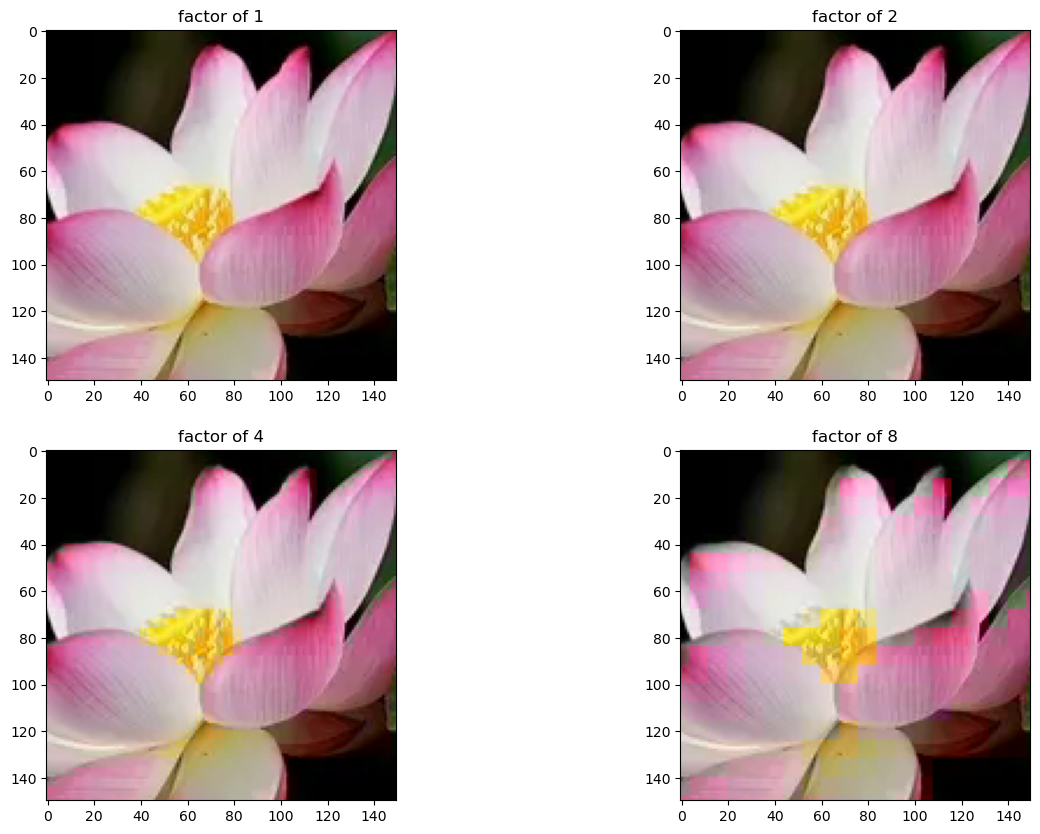

In [105]:
plt.figure(figsize=(15, 10))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(image_arr[i][100:250,300:450,:])
    plt.title("factor of " + str(1<<(i)))


As it is seen from above even though factor of 2 and 4 are not distinguishible from the original factor 8 is clearly over doned.

---
However the important point is the **original image and the factor of 2 are barerly different from each other**.
Even though we succed at contaminin the overl architecture of the image; with (1+0.25+0.25)/3 ,  we nearly reduce the image size by **half**